In [1]:


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv("spam.csv")
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


<AxesSubplot:xlabel='v1', ylabel='count'>

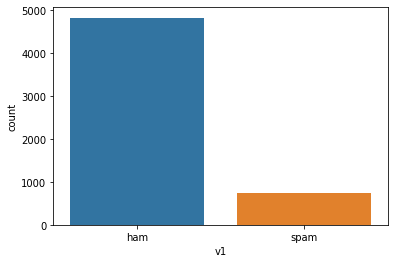

In [2]:
sns.countplot(x=data.v1)

We can see that our dataset contains mainly ham messages. This would limit the capability of model to classify correctly, but we can give it a try!

In [3]:


data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


We can see that v1 and v2 corresponds to whether the messages are ham/spam and the message text.
However, we'll need to look through the Unnamed fields to explore whether they have any effect on the final conclusion.

In [4]:
data["Unnamed: 2"].value_counts().head()

 bt not his girlfrnd... G o o d n i g h t . . .@"    3
GN                                                   2
 PO Box 5249                                         2
 but dont try to prove it..\" .Gud noon...."         2
this wont even start........ Datz confidence.."      2
Name: Unnamed: 2, dtype: int64

So we've 5 columns:
1. Containing the target whether the message is ham/spam
2. Text Field 1
3. Text Field 2
4. Text Field 4
5. Text Field 5

We can safely say that the amount of data in the Unnamed columns are negligible and can be dropped without any alterations to the remaining data.

Also, fortunately, we've no null values in v1 and v2

In [5]:


import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Deep
[nltk_data]     Mehta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:

import string
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer("english")

def simplify_data(data):
 

    
    data = pd.read_csv("spam.csv")         
    data["Spam"] = data.v1.map({'ham':0, 'spam':1})
    data["Text"] = data.v2.str.lower()
    data.Text = data.Text.str.replace(r'[.,\\&;!:-?(|)#@$^%*0-9/\'\"+={|}~`_[|]]*', '')
    data = data.drop(["v1", "v2", "Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
    return data
    
def remove_stopwords(message):
   
    
    stop_words = set(stopwords.words('english'))
    message = message.translate(str.maketrans('', '', string.punctuation))
    text = [word for word in message.split() if word not in stop_words and len(word) > 2]
    return " ".join(text)

def text_length(text):
    return len(text)
    
def format_length(data):
    data["Length"] = data.Text.apply(text_length)
    data.Length = pd.cut(data.Length, [-1, 10, 20, 30, 50, 75, 100, 999], labels=[10,20,30,50,75,100,200])
    return data
    
def apply_transformations(data):
    data = simplify_data(data)
    data.Text = data.Text.apply(remove_stopwords)
    data = format_length(data)
    return data

data = apply_transformations(data)
data.head()

,Spam,Text,Length
0,0,jurong point crazy available bugis great world...,75
1,0,lar joking wif oni,20
2,1,free entry wkly comp win cup final tkts may te...,100
3,0,dun say early hor already say,30
4,0,nah dont think goes usf lives around though,50


<AxesSubplot:xlabel='Length', ylabel='count'>

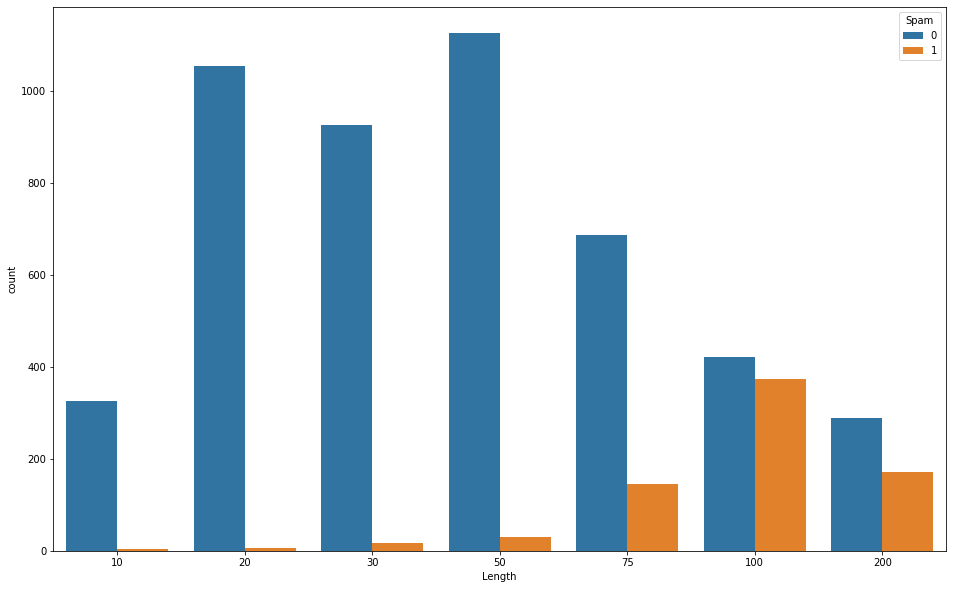

In [7]:
plt.figure(figsize=(16,10))
plt.xlabel("Length")
plt.ylabel("Number of Spam messages")
sns.countplot(x=data.Length, hue=data.Spam)

We can see that most messages with less length were mostly Ham messages and that the spam messages have a comparatively very small area. We can use this data further for classification. We also binned the lengths due to the broad spread it had previously.

In [8]:

spam_words = []
ham_words = []

def getSpam(text):
    global spam_words, spam_messages
    messages = text.split()
    words = [x for x in messages]
    spam_words += words
    
def getHam(text):
    global ham_words, ham_messages
    messages = text.split()
    words = [x for x in messages]
    ham_words += words
    

spam_messages = data[data["Spam"] == 1]["Text"]
ham_messages = data[data["Spam"] == 0]["Text"]


spam_messages.apply(getSpam)
ham_messages.apply(getHam)


def countSpam(text):
    count = 0
    for x in text.split():
        if x in spam_words:
            count += spam_words.count(x)
    return count

def countHam(text):
    count = 0
    for x in text.split():
        if x in ham_words:
            count += ham_words.count(x)
    return count

def getCounts(data):
    SpamCount = data.Text.apply(countSpam)
    HamCount = data.Text.apply(countHam)
    data["Diff"] = SpamCount - HamCount
    return data

def categorize(diff):
    if diff <= 0:
        return 0
    else:
        return 1

def apply_calc(data):
    data = getCounts(data)
    data.Diff = data.Diff.apply(categorize)
    return data

data = apply_calc(data)
data.head()

,Spam,Text,Length,Diff
0,0,jurong point crazy available bugis great world...,75,0
1,0,lar joking wif oni,20,0
2,1,free entry wkly comp win cup final tkts may te...,100,1
3,0,dun say early hor already say,30,0
4,0,nah dont think goes usf lives around though,50,0


In [9]:
spam_words.count("free")

219

In [10]:
ham_words.count("free")

59

Now that we've the algorithm to generate the required data(diff), we can try our model.

In [11]:
from sklearn.model_selection import train_test_split, GridSearchCV

X = data.drop(["Spam"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, data.Spam, test_size=0.2, random_state=23)

Since we already have aur generated outputs in Diff column, we can now check the accuracy of the model on the training data

In [12]:
from sklearn.metrics import accuracy_score, make_scorer
print("Accuracy on train data: ", accuracy_score(X_train.Diff, y_train))
print("Accuracy on test data: ", accuracy_score(X_test.Diff, y_test))

Accuracy on train data:  0.9524343728965672
Accuracy on test data:  0.9434977578475336


A 94-95% accuracy sounds good for using only one parameter!
However, we can further try using different models and try to include length as a parameter.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

X_train = X_train[["Length", "Diff"]]
X_test = X_test[["Length", "Diff"]]


clf = RandomForestClassifier()
parameters = {'n_estimators': [4, 6, 9], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
             }
acc_scorer = make_scorer(accuracy_score)
grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer, cv=3)
grid_obj = grid_obj.fit(X_train, y_train)
clf = grid_obj.best_estimator_

clf.fit(X_train, y_train)



preds = clf.predict(X_test)

clf_acc = nb_acc = accuracy_score(y_test, preds)
print("Accuracy with RandomForestClassifier: ", accuracy_score(y_test, preds))


svc_clf = SVC(gamma='scale')
svc_clf.fit(X_train,y_train)
svc_preds = svc_clf.predict(X_test)

svc_acc = accuracy_score(y_test, svc_preds)
print("Accuracy with SVC: ", accuracy_score(y_test, svc_preds))

nb = GaussianNB()
nb.fit(X_train, y_train)
nb_preds = nb.predict(X_test)

nb_acc = accuracy_score(y_test, nb_preds)
print("Accuracy with NaiveBayesian: ", accuracy_score(y_test, nb_preds))

Accuracy with RandomForestClassifier:  0.957847533632287
Accuracy with SVC:  0.8780269058295964
Accuracy with NaiveBayesian:  0.9434977578475336


We got a great accuracy with all models, including the programming approach! Our models are proving to be really great in detecting spam messages!

<AxesSubplot:xlabel='Length', ylabel='count'>

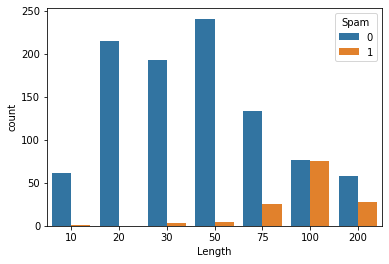

In [14]:
sns.countplot(x=X_test.Length, hue=y_test)

The model would be useless if we can't test custom inputs!
Finally we create a function to interact with front-end for predicting spam category for manual input.

Since we had the most accuracy with RandomForestClassifier, we'll use it for our predictions.

In [15]:


def manual_entry():
    global clf
    temp = pd.DataFrame(columns=["Text"])
    temp = temp.append({"Text": input("Enter message: ")}, ignore_index=True)

    temp = format_length(temp)
    temp = apply_calc(temp)
    temp = temp.drop(["Text"], axis=1)

    if temp.Diff.loc[0] == 1:
        print("Spam")
    else:
        print("Ham")
        
manual_entry()

Enter message: Congratulations! You've won a free phone. Call now on 9999999999
Spam


In [16]:
from sklearn.metrics import confusion_matrix
confusion_matrix(data.Spam, data.Diff)

array([[4723,  102],
       [ 173,  574]], dtype=int64)